In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
from pyspark.sql import SparkSession
from pyspark.sql.types import StructField, StructType, TimestampType, IntegerType
from pyspark.sql.functions import split, count, when, isnan, col, regexp_replace
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [2]:
spark = SparkSession.builder.appName('First Session').getOrCreate()

print('Spark Version: {}'.format(spark.version))

Spark Version: 3.5.0


In [3]:
#Defining a Schema
schema = StructType([StructField('Tanggal', TimestampType(), nullable = True),
                     StructField('DKI Jakarta', IntegerType(), nullable = True),
                     StructField('Jakarta Barat', IntegerType(), nullable = True),
                     StructField('Jakarta Selatan', IntegerType(), nullable = True),
                     StructField('Jakarta Timur', IntegerType(), nullable = True),
                     StructField('Jakarta Utara', IntegerType(), nullable = True)])

file_path = 'dataset_minyak_3tahun.csv'

df = spark.read.csv(file_path,
                    header = True,
                    inferSchema = True,
                    nanValue = '?')

df.show(5)

+----------+-------------+-------------+---------------+-------------+-------------+
|   Tanggal|Jakarta Barat|Jakarta Pusat|Jakarta Selatan|Jakarta Timur|Jakarta Utara|
+----------+-------------+-------------+---------------+-------------+-------------+
|2021-01-01|        14143|        13800|          14400|        13542|        13813|
|2021-01-02|        14000|        13700|          14500|        13375|        13813|
|2021-01-03|        14143|        13700|          14350|        13542|        13813|
|2021-01-04|        13929|        13750|          14250|        13542|        13813|
|2021-01-05|        14000|        13850|          14200|        13542|        13813|
+----------+-------------+-------------+---------------+-------------+-------------+
only showing top 5 rows



In [4]:
# Tampilkan jumlah data
print(df.count())

1086


In [5]:
#Check column names
df.columns

['Tanggal',
 'Jakarta Barat',
 'Jakarta Pusat',
 'Jakarta Selatan',
 'Jakarta Timur',
 'Jakarta Utara']

In [6]:
#Display data with pandas format
df.toPandas().head()

,Tanggal,Jakarta Barat,Jakarta Pusat,Jakarta Selatan,Jakarta Timur,Jakarta Utara
0,2021-01-01,14143,13800.0,14400,13542,13813
1,2021-01-02,14000,13700.0,14500,13375,13813
2,2021-01-03,14143,13700.0,14350,13542,13813
3,2021-01-04,13929,13750.0,14250,13542,13813
4,2021-01-05,14000,13850.0,14200,13542,13813


In [7]:
#Check the schema
df.printSchema()

root
 |-- Tanggal: date (nullable = true)
 |-- Jakarta Barat: integer (nullable = true)
 |-- Jakarta Pusat: integer (nullable = true)
 |-- Jakarta Selatan: integer (nullable = true)
 |-- Jakarta Timur: integer (nullable = true)
 |-- Jakarta Utara: integer (nullable = true)



In [8]:
#statistical summary of dataframe
df.describe().show()

+-------+-----------------+------------------+------------------+------------------+------------------+
|summary|    Jakarta Barat|     Jakarta Pusat|   Jakarta Selatan|     Jakarta Timur|     Jakarta Utara|
+-------+-----------------+------------------+------------------+------------------+------------------+
|  count|             1086|              1085|              1086|              1086|              1086|
|   mean|16009.45488029466|15894.107834101382| 16210.82965009208|15781.101289134438|15845.511049723757|
| stddev|1618.664296391923|1623.9473497680397|1951.2960021495544|1658.4273836879597|1717.4257972332373|
|    min|            13267|             13450|             13800|             13375|             13417|
|    max|            20250|             19650|             22286|             20100|             22000|
+-------+-----------------+------------------+------------------+------------------+------------------+



In [9]:
#describe with specific variables
df.describe(['Jakarta Pusat', 'Jakarta Selatan']).show()

+-------+------------------+------------------+
|summary|     Jakarta Pusat|   Jakarta Selatan|
+-------+------------------+------------------+
|  count|              1085|              1086|
|   mean|15894.107834101382| 16210.82965009208|
| stddev|1623.9473497680397|1951.2960021495544|
|    min|             13450|             13800|
|    max|             19650|             22286|
+-------+------------------+------------------+



In [10]:
#describe with numerical columns
def get_num_cols(dataframe):
    
    num_cols = [col for col in dataframe.columns if dataframe.select(col). \
                dtypes[0][1] in ['double', 'int']]
    
    return num_cols

num_cols = get_num_cols(df)
    
df.describe(num_cols).show()

+-------+-----------------+------------------+------------------+------------------+------------------+
|summary|    Jakarta Barat|     Jakarta Pusat|   Jakarta Selatan|     Jakarta Timur|     Jakarta Utara|
+-------+-----------------+------------------+------------------+------------------+------------------+
|  count|             1086|              1085|              1086|              1086|              1086|
|   mean|16009.45488029466|15894.107834101382| 16210.82965009208|15781.101289134438|15845.511049723757|
| stddev|1618.664296391923|1623.9473497680397|1951.2960021495544|1658.4273836879597|1717.4257972332373|
|    min|            13267|             13450|             13800|             13375|             13417|
|    max|            20250|             19650|             22286|             20100|             22000|
+-------+-----------------+------------------+------------------+------------------+------------------+



In [11]:
#Filter & sortir
df.filter(df['Jakarta Timur'] > 18000).filter(df['Jakarta Barat'] > 18000).filter(df['Jakarta Utara'] > 17000).filter(df['Jakarta Selatan'] > 18000).filter(df['Jakarta Pusat'] > 18000).show(5)

+----------+-------------+-------------+---------------+-------------+-------------+
|   Tanggal|Jakarta Barat|Jakarta Pusat|Jakarta Selatan|Jakarta Timur|Jakarta Utara|
+----------+-------------+-------------+---------------+-------------+-------------+
|2021-11-08|        18083|        18300|          19300|        18500|        17875|
|2021-11-11|        18583|        18200|          19400|        18750|        18429|
|2021-11-17|        19250|        18100|          19400|        18875|        19214|
|2021-11-18|        19250|        18200|          19500|        18875|        19357|
|2021-11-19|        19417|        18200|          19600|        18917|        19071|
+----------+-------------+-------------+---------------+-------------+-------------+
only showing top 5 rows



In [12]:
#Multiple Conditions
df.filter((df['Jakarta Barat'] > 18000) & 
          (df['Jakarta Pusat'] > 18000) & 
          (df['Jakarta Selatan'] > 18000) & 
          (df['Jakarta Timur'] > 18000) &
          (df['Jakarta Utara'] > 18000)).select('Tanggal').show(5)

+----------+
|   Tanggal|
+----------+
|2021-11-11|
|2021-11-17|
|2021-11-18|
|2021-11-19|
|2021-11-20|
+----------+
only showing top 5 rows



In [13]:
#Sorting
df.filter((df['Jakarta Pusat'] > 18000) & (df['Jakarta Selatan'] == 20000)). \
orderBy('Jakarta Pusat', ascending = False).select('Tanggal', 'Jakarta Pusat', 'Jakarta Selatan').show(5)

+----------+-------------+---------------+
|   Tanggal|Jakarta Pusat|Jakarta Selatan|
+----------+-------------+---------------+
|2021-12-24|        19500|          20000|
|2022-01-20|        19450|          20000|
|2021-12-17|        19400|          20000|
|2021-12-20|        19400|          20000|
|2021-12-25|        19400|          20000|
+----------+-------------+---------------+
only showing top 5 rows



In [14]:
df.filter(df['Tanggal'].like('%2023-12%')).show(20)

+----------+-------------+-------------+---------------+-------------+-------------+
|   Tanggal|Jakarta Barat|Jakarta Pusat|Jakarta Selatan|Jakarta Timur|Jakarta Utara|
+----------+-------------+-------------+---------------+-------------+-------------+
|2023-12-01|        15500|        15778|          15786|        15750|        15800|
|2023-12-02|        15714|        15667|          15857|        15850|        15667|
|2023-12-03|        15571|        15667|          15786|        15813|        16000|
|2023-12-04|        15714|        15778|          15786|        15850|        15600|
|2023-12-05|        15714|        15778|          15786|        15750|        15667|
|2023-12-06|        15714|        15778|          15786|        15773|        15667|
|2023-12-07|        15714|        15889|          15786|        15773|        15667|
|2023-12-08|        15667|        15778|          13871|        15833|        15500|
|2023-12-09|        15667|        15875|          15929|        1

In [15]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_timestamp

# Convert string date column to timestamp
df = df.withColumn("tanggal", to_timestamp(df["tanggal"]))

df.show(5)

# Convert timestamp to numeric (Unix timestamp in seconds)
df = df.withColumn("timestamp_numeric", df["tanggal"].cast("long"))
df.printSchema()

+-------------------+-------------+-------------+---------------+-------------+-------------+
|            tanggal|Jakarta Barat|Jakarta Pusat|Jakarta Selatan|Jakarta Timur|Jakarta Utara|
+-------------------+-------------+-------------+---------------+-------------+-------------+
|2021-01-01 00:00:00|        14143|        13800|          14400|        13542|        13813|
|2021-01-02 00:00:00|        14000|        13700|          14500|        13375|        13813|
|2021-01-03 00:00:00|        14143|        13700|          14350|        13542|        13813|
|2021-01-04 00:00:00|        13929|        13750|          14250|        13542|        13813|
|2021-01-05 00:00:00|        14000|        13850|          14200|        13542|        13813|
+-------------------+-------------+-------------+---------------+-------------+-------------+
only showing top 5 rows

root
 |-- tanggal: timestamp (nullable = true)
 |-- Jakarta Barat: integer (nullable = true)
 |-- Jakarta Pusat: integer (nullabl

In [16]:
# Buat VectorAssembler untuk menggabungkan fitur
assembler = VectorAssembler(inputCols=['timestamp_numeric'], outputCol='features', handleInvalid='skip')

# Transformasi DataFrame menggunakan VectorAssembler
df = assembler.transform(df)
# Hilangkan baris yang mengandung nilai null setelah transformasi
df = df.dropna()

In [17]:
# Pembagian data menjadi train dan test (80-20%)
train_data, test_data = df.randomSplit([0.8, 0.2], seed=123)

In [18]:
# Membuat model Linear Regression
lr_jakbar = LinearRegression(labelCol='Jakarta Barat', featuresCol='features')
lr_jaksel = LinearRegression(labelCol='Jakarta Selatan', featuresCol='features')
lr_jakpus = LinearRegression(labelCol='Jakarta Pusat', featuresCol='features')
lr_jaktim = LinearRegression(labelCol='Jakarta Timur', featuresCol='features')
lr_jakut = LinearRegression(labelCol='Jakarta Utara', featuresCol='features')

# Melatih model menggunakan data training
model_jakbar = lr_jakbar.fit(train_data)
model_jaksel = lr_jaksel.fit(train_data)
model_jakpus = lr_jakpus.fit(train_data)
model_jaktim = lr_jaktim.fit(train_data)
model_jakut = lr_jakut.fit(train_data)

In [20]:
# Melakukan prediksi menggunakan data test
predictions_jakbar = model_jakbar.transform(test_data)
predictions_jaksel = model_jaksel.transform(test_data)
predictions_jakpus = model_jakpus.transform(test_data)
predictions_jaktim = model_jaktim.transform(test_data)
predictions_jakut = model_jakut.transform(test_data)

predictions_jakbar.printSchema()
predictions_jaksel.printSchema()
predictions_jakpus.printSchema()
predictions_jaktim.printSchema()
predictions_jakut.printSchema()

# Tampilkan hasil prediksi
predictions_jakbar.show()
predictions_jaksel.show()
predictions_jakpus.show()
predictions_jaktim.show()
predictions_jakut.show()

root
 |-- tanggal: timestamp (nullable = true)
 |-- Jakarta Barat: integer (nullable = true)
 |-- Jakarta Pusat: integer (nullable = true)
 |-- Jakarta Selatan: integer (nullable = true)
 |-- Jakarta Timur: integer (nullable = true)
 |-- Jakarta Utara: integer (nullable = true)
 |-- timestamp_numeric: long (nullable = true)
 |-- features: vector (nullable = true)
 |-- prediction: double (nullable = false)

root
 |-- tanggal: timestamp (nullable = true)
 |-- Jakarta Barat: integer (nullable = true)
 |-- Jakarta Pusat: integer (nullable = true)
 |-- Jakarta Selatan: integer (nullable = true)
 |-- Jakarta Timur: integer (nullable = true)
 |-- Jakarta Utara: integer (nullable = true)
 |-- timestamp_numeric: long (nullable = true)
 |-- features: vector (nullable = true)
 |-- prediction: double (nullable = false)

root
 |-- tanggal: timestamp (nullable = true)
 |-- Jakarta Barat: integer (nullable = true)
 |-- Jakarta Pusat: integer (nullable = true)
 |-- Jakarta Selatan: integer (nullable =

+-------------------+-------------+-------------+---------------+-------------+-------------+-----------------+-------------+------------------+
|            tanggal|Jakarta Barat|Jakarta Pusat|Jakarta Selatan|Jakarta Timur|Jakarta Utara|timestamp_numeric|     features|        prediction|
+-------------------+-------------+-------------+---------------+-------------+-------------+-----------------+-------------+------------------+
|2021-01-03 00:00:00|        14143|        13700|          14350|        13542|        13813|       1609606800|[1.6096068E9]|15445.799214001709|
|2021-01-07 00:00:00|        14000|        13750|          14300|        13583|        13813|       1609952400|[1.6099524E9]|15449.228807898098|
|2021-01-13 00:00:00|        13857|        13850|          14200|        13500|        13813|       1610470800|[1.6104708E9]| 15454.37319874268|
|2021-01-14 00:00:00|        14143|        13950|          14250|        13500|        13875|       1610557200|[1.6105572E9]|15455

In [21]:
from pyspark.sql.functions import monotonically_increasing_id

predictions_jakbar = predictions_jakbar.withColumn("index", monotonically_increasing_id())
predictions_jaksel = predictions_jaksel.withColumn("index", monotonically_increasing_id())
predictions_jakpus = predictions_jakpus.withColumn("index", monotonically_increasing_id())
predictions_jaktim = predictions_jaktim.withColumn("index", monotonically_increasing_id())
predictions_jakut = predictions_jakut.withColumn("index", monotonically_increasing_id())

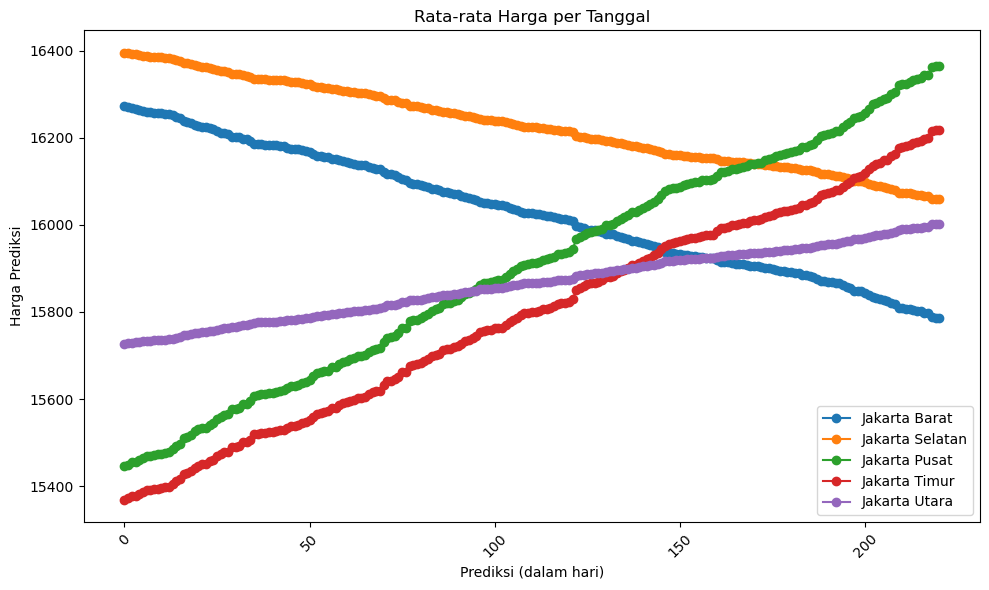

In [27]:
import matplotlib.pyplot as plt


# Ambil harga minyak goreng rata-rata sebagai array NumPy
jakbar = predictions_jakbar.select("prediction").toPandas()["prediction"].to_numpy()
jaksel = predictions_jaksel.select("prediction").toPandas()["prediction"].to_numpy()
jakpus = predictions_jakpus.select("prediction").toPandas()["prediction"].to_numpy()
jaktim = predictions_jaktim.select("prediction").toPandas()["prediction"].to_numpy()
jakut = predictions_jakut.select("prediction").toPandas()["prediction"].to_numpy()

# bulan = predictions.select(["bulan_tahun"]).toPandas()["bulan_tahun"].to_numpy()
index_jakbar = predictions_jakbar.select(["index"]).toPandas()["index"].to_numpy()
index_jaksel = predictions_jaksel.select(["index"]).toPandas()["index"].to_numpy()
index_jakpus = predictions_jakpus.select(["index"]).toPandas()["index"].to_numpy()
index_jaktim = predictions_jaktim.select(["index"]).toPandas()["index"].to_numpy()
index_jakut = predictions_jakut.select(["index"]).toPandas()["index"].to_numpy()

# Visualisasi menggunakan Matplotlib
plt.figure(figsize=(10, 6))

plt.plot(index_jakbar, jakbar, label="Jakarta Barat", marker='o', linestyle='-')
plt.plot(index_jaksel, jaksel, label="Jakarta Selatan", marker='o', linestyle='-')
plt.plot(index_jakpus, jakpus, label="Jakarta Pusat", marker='o', linestyle='-')
plt.plot(index_jaktim, jaktim, label="Jakarta Timur", marker='o', linestyle='-')
plt.plot(index_jakut, jakut, label="Jakarta Utara", marker='o', linestyle='-')

plt.title("Rata-rata Harga per Tanggal")
plt.xlabel("Prediksi (dalam hari)")
plt.ylabel("Harga Prediksi")
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

In [29]:
spark.stop()